## Introduction

The present function will train and evaluate the VotingClassifier based on the parameters given by the user:
- Selected dataset, can be dataset1, dataset2, dataset3
- Select label feature: 0 (binary), 1(multiclass)
- Normalisation: 0 ('No'), 1 ('Yes')
- Feature engineering: 0 (sel_features by user)
- Evaluation metrics: precision & recall & f1 (and respectively macro and weighted)
- Validation scheme: cross-validation with CVGridSearch and KFoldStratified
- split_proportion: a value for the test proportion can be btw 0 and 1, usually 0.2

In [1]:
# import modules

import numpy as np
import pandas as pd

import gc

import seaborn as sns
import math
import matplotlib as mpl
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import accuracy_score, average_precision_score,make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import time

np.random.seed(2)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
dataset = 2
label_feature = 0
norm_values = 1
evaluation_metrics = ['f1_macro','f1_weighted',\
                      'precision_macro','precision_weighted',\
                      'recall_macro','recall','roc_auc']
if dataset == 1:
    indices_reasons = [0,5,6,7,8,9,10,11,15]
elif dataset == 2:
    indices_reasons = [0,3,4,5,6,7,8,9,10,11,15,20]
elif dataset == 3:
    indices_reasons = [-1,0,1,2,3,4,5,6,7,8,9,10,11,15,20]

if label_feature == 0:
    label_class = 'Class'
    class_names = ['Accepted','Rejected']
    scores = {'f1-macro': evaluation_metrics[0], \
           'f1-weighted': evaluation_metrics[1], \
           'Precision-macro': evaluation_metrics[2], \
           'Precision-weighted': evaluation_metrics[3], \
           'Recall-macro': evaluation_metrics[4],\
           'Recall': evaluation_metrics[5],\
           'ROC': evaluation_metrics[6]}
    colors = ['g','k','b','r','y','c','m']
else:
    label_class = 'Justification_reason'
    scores = {'f1-macro': evaluation_metrics[0],
             'f1_weighted': make_scorer(f1_score, average = 'weighted'),
             'precision': make_scorer(precision_score, average = 'macro'),
             'precision': make_scorer(precision_score, average = 'weighted'),
             'recall': make_scorer(recall_score, average = 'macro'),
             'recall': make_scorer(recall_score, average = 'weighted')}
    colors = ['g','k','b','r','y','c']
    if dataset == 1:
        class_names = ['Accepted','RR-4','RR-5','RR-6','RR-7','RR-8',\
                      'RR-9','RR-10','RR_11','Other-R']
    elif dataset ==2:
        class_names = ['Accepted','RR-4','RR-5','RR-6','RR-7','RR-8',\
                      'RR-9','RR-10','RR_11','Other-R','No-R']
    elif dataset == 3:
        class_names = ['Accepted','RR-1','RR-2','RR-3','RR-4','RR-5','RR-6','RR-7','RR-8',\
                      'RR-9','RR-10','RR_11','Other-R','No-R']

# The hyperparameter grid for the optimization will be specified in the sequel
validation_scheme = 0
split_proportion = 0.1

In [3]:
seed = 42
np.random.seed(seed)

In [4]:
import pickle
# read the pkl with the labeled dataset:
df_cleandata = pd.read_pickle('AllData_AI_ALL_NotEncoded.pkl')
# The dataset contains 6'851'424 entities and 62 columns (fields, features);
# while most of the categorical fields were converted to numerical ones, few fields remains in text format: 
# Explanation, ClaimExplanation, Justification, Adjustment
# Indeed, these fields will not be used for the training, but will be used as a complementary information in the analysis
# of the performance of the model the data is not normalized

memStats = df_cleandata.memory_usage()
labeldataShape = df_cleandata.shape
print(f'''The labeled dataset has \
{labeldataShape[0]} rows and {labeldataShape[1]} columns. 
Memory consumption in megabytes(MB): {round((memStats/1024/1024).sum(),2)}''')

The labeled dataset has 18621821 rows and 93 columns. 
Memory consumption in megabytes(MB): 13354.88


In [5]:
def selection_data(df,sel_columns,text_columns,indices_reasons,verbose):
    # This function is created in order to allow the selection of columns and rejected data
    # The selection of columns concern the input data for the AI model
    # we can select only partially the rejection classes, or all
    # the output:
    #   - df_new: the input data for the AI model (not yet normalized)
    #   - df_reasons: the df relative to the rejection reasons (contains fields like 
    #     Explanation, ClaimExplanation, Justification, Adjustment, Justification reason)
    index = (df['Justification_reason'].isin(indices_reasons))
    df_new = df.loc[index,sel_columns].copy().reset_index()
    df_reasons = df.loc[index,text_columns].copy().reset_index()
    if verbose == True:
        print("Justification reasons:")
        print(round(df_reasons['Justification_reason'].value_counts(normalize=True).sort_index()*100,2))
        print(f'''Initial nb of rows: {df.shape[0]}, final dimension: {df_new.shape[0]}''')
        print(df_reasons.shape)
    return df_new, df_reasons

In [6]:
# Columns that were previously selected
selected_cols = ['ItemUUID', 'ClaimUUID', 'ClaimAdminUUID', 'HFUUID', 'LocationUUID', 'HFLocationUUID','InsureeUUID',\
                 'FamilyUUID', 'ICDID', 'ICDID1',\
                 'QtyProvided','PriceAsked', 'ItemPrice',\
                 'ItemFrequency', 'ItemPatCat', 'ItemLevel', \
                 'DateFrom', 'DateTo', 'DateClaimed', 'Age', \
                 'VisitType',  'HFLevel', 'HFCareType',  \
                 'Gender', 'ItemServiceType']
text_cols = ['ClaimExplanation', 'Explanation', 'Adjustment', \
             'Justification', 'Justification_reason','Class']

selected_cols.append(label_class)

In [7]:
# create the dataframe with the selected columns and the associated dataframe wrt reasons
df_data, df_reasons = selection_data(df_cleandata,selected_cols,text_cols,indices_reasons,True)

df_data_noR, df_reasons_noR = selection_data(df_cleandata,selected_cols,text_cols,[20],True)
# Remark: the dataframe df_data contains two label columns: Justification reasons and Class
# depending on the objective, we need to drop one column or another

# labels = ['1: Missing or unclear document(s) (18.18%)',\
#           '2:According to document (2.71%)',\
#           '3: Missing values (0.17%)',\
#           '4:Need to be claimed individually (0.48%)',\
#           '5: Free item (0.04%)',\
#           '6: Time related issues (5.78%)',\
#           '7: Dosage related issues (0.04%)',\
#           '8: Large quantities (0.39%)',
#           '9: Multiple submission (10%)',\
#           '10: Inconsistency btw ICDID and items (1.08%)',\
#           '11: Item included in package (20.88%)',\
#           '12: Other reasons (0.88%)',\
#           '20: No given reason (39.34%)']  

Justification reasons:
0.0     97.35
3.0      0.01
4.0      0.02
5.0      0.00
6.0      0.22
7.0      0.00
8.0      0.02
9.0      0.38
10.0     0.04
11.0     0.80
15.0     0.03
20.0     1.13
Name: Justification_reason, dtype: float64
Initial nb of rows: 18621821, final dimension: 6772115
(6772115, 7)
Justification reasons:
20.0    100.0
Name: Justification_reason, dtype: float64
Initial nb of rows: 18621821, final dimension: 76761
(76761, 7)


In [8]:
del [[df_cleandata]]
gc.collect()
df_cleandata=pd.DataFrame()

In [9]:
# Convert the class field to numeric

index_accepted = df_reasons[label_class]=='Accepted'
df_reasons.loc[index_accepted,label_class] = 0
df_reasons.loc[~index_accepted,label_class] = 1

df_reasons[label_class] = pd.to_numeric(df_reasons[label_class])

index_accepted = df_data[label_class]=='Accepted'
df_data.loc[index_accepted,label_class] = 0
df_data.loc[~index_accepted,label_class] = 1

df_data[label_class] = pd.to_numeric(df_data[label_class])

In [10]:
## split the dataset

y = df_data[label_class]
X = df_data.drop([label_class], axis=1).copy()
X[text_cols]=df_reasons[text_cols]

X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, \
                                                    test_size=split_proportion,\
                                                    stratify=y, random_state=0)
X_train = X_train_all[selected_cols[:-1]].copy()
X_test  = X_test_all[selected_cols[:-1]]
X_train_JR = X_train_all[text_cols]
X_test_JR  = X_test_all[text_cols]

# .drop(text_cols, axis=1, inplace=True)

print("Number of rows in X_train dataset: ", X_train.shape)
print("Number of rows in y_train dataset: ", y_train.shape)
print("Number of rows in X_test dataset: ", X_test.shape)
print("Number of rows in y_test dataset: ", y_test.shape)
print("Number of rows in X_train_JR dataset: ", X_train_JR.shape)

print("Number of rows in X_test_JR dataset: ", X_test_JR.shape)

Number of rows in X_train dataset:  (6094903, 25)
Number of rows in y_train dataset:  (6094903,)
Number of rows in X_test dataset:  (677212, 25)
Number of rows in y_test dataset:  (677212,)
Number of rows in X_train_JR dataset:  (6094903, 6)
Number of rows in X_test_JR dataset:  (677212, 6)


In [11]:
# Get categorical fields:
obj_df = df_data.select_dtypes(include=['object']).copy()
print(list(obj_df))

['ItemUUID', 'ClaimUUID', 'ClaimAdminUUID', 'HFUUID', 'LocationUUID', 'HFLocationUUID', 'InsureeUUID', 'FamilyUUID', 'ItemLevel', 'VisitType', 'HFLevel', 'HFCareType', 'Gender', 'ItemServiceType']


In [12]:
import category_encoders as ce

cat_features = ['ItemUUID', 'ClaimUUID', 'ClaimAdminUUID', 'HFUUID',
            'LocationUUID', 'HFLocationUUID', 'InsureeUUID', 
            'FamilyUUID', 'ItemLevel', 'VisitType', 'HFLevel',
            'HFCareType', 'Gender', 'ItemServiceType']

# Create the encoder itself
target_enc = ce.TargetEncoder(cols=cat_features)

# Fit the encoder using the categorical features and target
target_enc.fit(X_train[cat_features],y_train)

X_train[cat_features] = target_enc.transform(X_train[cat_features])
X_test[cat_features]  = target_enc.transform(X_test[cat_features])

X_train[cat_features] = X_train[cat_features].apply(pd.to_numeric)
X_test[cat_features] = X_test[cat_features].apply(pd.to_numeric)

In [13]:
# filehandler = open("Encoder_protocol4.obj","wb")
# pickle.dump(target_enc,filehandler,protocol=4)
# filehandler.close()

filehandler = open("Encoder_protocol5.obj","wb")
pickle.dump(target_enc,filehandler,protocol=5)
filehandler.close()

In [14]:
## Normalization

if norm_values >0:
    if norm_values == 1:
        scaler = StandardScaler()
    elif norm_values == 2:
        scaler = RobustScaler(quantile_range=(25, 75))
    scaler.fit_transform(X_train)
    X_train =pd.DataFrame(data=scaler.transform(X_train), columns=selected_cols[:-1])
    X_test = pd.DataFrame(data=scaler.transform(X_test), columns=selected_cols[:-1])

# save the model
# pickle.dump(scaler, open('scaler_protocol4.pkl', 'wb'),protocol=4)
# pickle.dump(scaler, open('scaler_protocol5.pkl', 'wb'),protocol=5)    

In [15]:
del [[X_train_all,X_test_all,X,y]]
gc.collect()
X_train_all=pd.DataFrame()
X_test_all=pd.DataFrame()
X = pd.DataFrame()
y = pd.DataFrame()

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Define the classifiers to be used for the VotingClassifier ensemble:
clf1 = ExtraTreesClassifier(criterion = 'entropy',
                            class_weight=None,
                            max_depth=75,
                            max_features=None,
                            min_samples_leaf=4,
                            min_samples_split=14,
                            bootstrap = False,
                            n_estimators=100)
clf2 = RandomForestClassifier(criterion = 'entropy',
                              class_weight=None,
                              max_depth=25,
                              max_features='sqrt',
                              min_samples_leaf = 6,
                              min_samples_split = 4,
                              bootstrap = False,
                              n_estimators=100,
                              n_jobs=-1)
clf3 = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth=50,
                              min_samples_leaf = 32,
                              min_samples_split = 26)
# clf4 = DecisionTreeClassifier(class_weight='balanced',
#                               max_depth=15,
#                               min_samples_leaf = 32,
#                               min_samples_split = 26)
clf5 = XGBClassifier(objective ='binary:logistic',
                        learning_rate= 0.10,
                        max_depth= 25,
                        subsample= 1,
                        colsample_bytree=  0.9,
                        scale_pos_weight= 1)

# # Combine the classifiers in the ensemble model
# # ('lr', clf1),
ensemble_model_hard = VotingClassifier(estimators=[('XTC', clf1), 
                                              ('rf', clf2),
#                                               ('dt1', clf3),
                                              ('xgb',clf5)],
                                  voting='hard',
                                 n_jobs=10,
                                 verbose=True)

# # Fit the model to your training data and get the predicted results
ensemble_model_hard.fit(X_train,y_train)
y_predicted_hard = ensemble_model_hard.predict(X_test)

In [17]:
import joblib

joblib_file = "joblib_Voting_Model.pkl"  
joblib.dump(ensemble_model_hard, joblib_file)

['joblib_Voting_Model.pkl']

In [18]:
y_test_all = pd.DataFrame()
y_test_all['True'] = np.array(y_test)
y_test_all['Predicted'] = np.array(y_predicted_hard)

In [19]:
# y_test_all.to_pickle('TestData_y.pkl') 
# X_test.to_pickle('TestData_X.pkl') 

In [20]:
# Print Classification report and Confusion matrix of the model
print('Classifier report:\n',classification_report(y_test,y_predicted_hard, digits=4))
print('Confusion matrix:\n',confusion_matrix(y_test,y_predicted_hard))

Classifier report:
               precision    recall  f1-score   support

           0     0.9897    0.9967    0.9932    659235
           1     0.8362    0.6209    0.7127     17977

    accuracy                         0.9867    677212
   macro avg     0.9130    0.8088    0.8529    677212
weighted avg     0.9857    0.9867    0.9857    677212

Confusion matrix:
 [[657049   2186]
 [  6815  11162]]


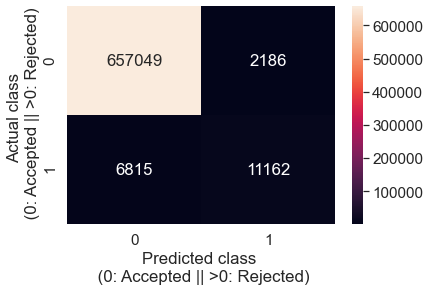

In [21]:
cm2 = confusion_matrix(y_test,y_predicted_hard)
# plt.figure(figsize=(20,15))
sns.set(font_scale=1.4)
ax=sns.heatmap(cm2, annot=True, fmt='g')
ax.set(xlabel='Predicted class \n (0: Accepted || >0: Rejected)', 
       ylabel='Actual class \n (0: Accepted || >0: Rejected)')
plt.show()

## Analyse the classifiers results

In [22]:
# Extra Trees Classifier

clf1_trained = clf1.fit(X_train,y_train)
y_pred_train_1 = clf1_trained.predict(X_train)
y_pred_test_1  = clf1_trained.predict(X_test)

print('Classifier report:\n',classification_report(y_test,y_pred_test_1,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_test_1))

print('Classifier report:\n',classification_report(y_train,y_pred_train_1,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_train,y_pred_train_1))

Classifier report:
               precision    recall  f1-score   support

           0     0.9896    0.9964    0.9930    659235
           1     0.8238    0.6173    0.7058     17977

    accuracy                         0.9863    677212
   macro avg     0.9067    0.8069    0.8494    677212
weighted avg     0.9852    0.9863    0.9854    677212

Confusion matrix:
 [[656861   2374]
 [  6879  11098]]
Classifier report:
               precision    recall  f1-score   support

           0     0.9966    0.9988    0.9977   5933114
           1     0.9533    0.8734    0.9116    161789

    accuracy                         0.9955   6094903
   macro avg     0.9749    0.9361    0.9546   6094903
weighted avg     0.9954    0.9955    0.9954   6094903

Confusion matrix:
 [[5926190    6924]
 [  20480  141309]]


In [23]:
# Random Forest classifier
clf2_trained = clf2.fit(X_train,y_train)
y_pred_train_2 = clf2_trained.predict(X_train)
y_pred_test_2  = clf2_trained.predict(X_test)

print('Classifier report:\n',classification_report(y_test,y_pred_test_2,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_test_2))

print('Classifier report:\n',classification_report(y_train,y_pred_train_2,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_train,y_pred_train_2))

Classifier report:
               precision    recall  f1-score   support

           0     0.9896    0.9969    0.9932    659235
           1     0.8431    0.6173    0.7128     17977

    accuracy                         0.9868    677212
   macro avg     0.9164    0.8071    0.8530    677212
weighted avg     0.9858    0.9868    0.9858    677212

Confusion matrix:
 [[657170   2065]
 [  6879  11098]]
Classifier report:
               precision    recall  f1-score   support

           0     0.9967    0.9990    0.9978   5933114
           1     0.9605    0.8769    0.9168    161789

    accuracy                         0.9958   6094903
   macro avg     0.9786    0.9380    0.9573   6094903
weighted avg     0.9957    0.9958    0.9957   6094903

Confusion matrix:
 [[5927286    5828]
 [  19919  141870]]


In [24]:
# DecisionTree CLassifier
clf3_trained = clf3.fit(X_train,y_train)
y_pred_train_3 = clf3_trained.predict(X_train)
y_pred_test_3  = clf3_trained.predict(X_test)

print('Classifier report:\n',classification_report(y_test,y_pred_test_3,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_test_3))

print('Classifier report:\n',classification_report(y_train,y_pred_train_3,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_train,y_pred_train_3))

Classifier report:
               precision    recall  f1-score   support

           0     0.9893    0.9956    0.9924    659235
           1     0.7885    0.6047    0.6845     17977

    accuracy                         0.9852    677212
   macro avg     0.8889    0.8001    0.8384    677212
weighted avg     0.9840    0.9852    0.9842    677212

Confusion matrix:
 [[656320   2915]
 [  7107  10870]]
Classifier report:
               precision    recall  f1-score   support

           0     0.9946    0.9972    0.9959   5933114
           1     0.8851    0.8000    0.8404    161789

    accuracy                         0.9919   6094903
   macro avg     0.9398    0.8986    0.9181   6094903
weighted avg     0.9917    0.9919    0.9917   6094903

Confusion matrix:
 [[5916311   16803]
 [  32360  129429]]


In [25]:
# Extra Gradient Boost
clf5_trained = clf5.fit(X_train,y_train)
y_pred_train_5 = clf5_trained.predict(X_train)
y_pred_test_5  = clf5_trained.predict(X_test)

print('Classifier report:\n',classification_report(y_test,y_pred_test_5,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred_test_5))

print('Classifier report:\n',classification_report(y_train,y_pred_train_5,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_train,y_pred_train_5))

[10:46:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier report:
               precision    recall  f1-score   support

           0     0.9900    0.9958    0.9929    659235
           1     0.8047    0.6313    0.7075     17977

    accuracy                         0.9861    677212
   macro avg     0.8973    0.8135    0.8502    677212
weighted avg     0.9851    0.9861    0.9853    677212

Confusion matrix:
 [[656480   2755]
 [  6629  11348]]
Classifier report:
               precision    recall  f1-score   support

           0     0.9989    0.9996    0.9993   5933114
           1     0.9844    0.9614    0.9727    161789

    accuracy                         0.9986   6094903
   macro avg     0.9917    0.9805    0.9860   60949

In [26]:
clf1_probs = clf1_trained.predict_proba(X_test)
clf2_probs = clf2_trained.predict_proba(X_test)
clf5_probs = clf5_trained.predict_proba(X_test)

In [28]:
X_results = pd.DataFrame()

X_results['Class'] = np.array(y_test)
X_results['Voting'] = np.array(y_predicted_hard)
X_results['ExtraTrees'] = np.array(y_pred_test_1)
X_results['RandomForest'] = np.array(y_pred_test_2)
X_results['XGB'] = np.array(y_pred_test_5)

# X_test_results['Justification_reason'] = np.array(X_test_JR['Justification_reason'])

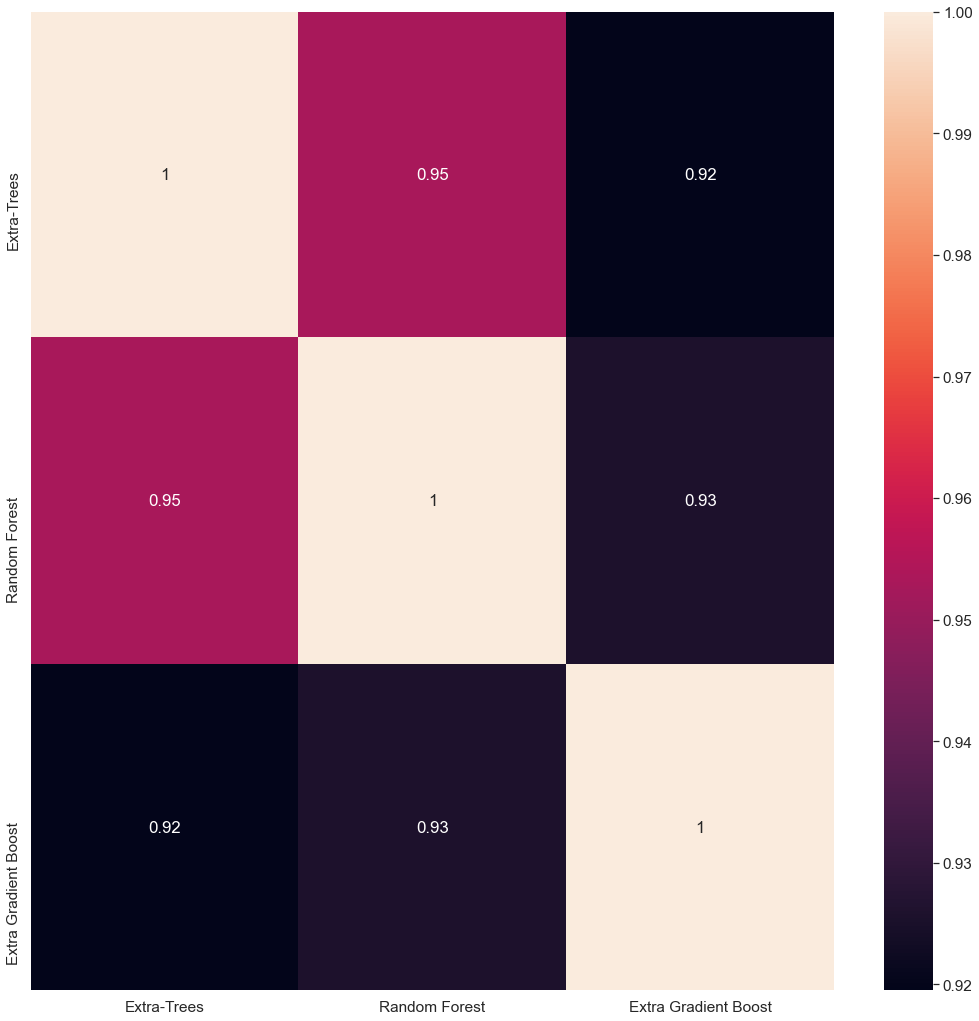

In [29]:
corr = pd.concat([pd.Series(y_pred_test_1, name="Extra-Trees"),
                  pd.Series(y_pred_test_2, name="Random Forest"), 
                  pd.Series(y_pred_test_5, name="Extra Gradient Boost")],axis=1)

plt.figure(figsize=(18,18))
sns.set(font_scale=1.4)
sns.heatmap(corr.corr(),annot=True)
plt.show()

In [30]:
# corr = pd.concat([pd.Series(y_pred_test_1, name="EXT"),
#                   pd.Series(y_pred_test_2, name="RF"),
#                   pd.Series(y_pred_test_3, name="DT1"), 
#                   pd.Series(y_pred_test_5, name="XGB")],axis=1)

# plt.figure(figsize=(18,18))
# sns.heatmap(corr.corr(),annot=True)
# plt.show()